<a href="https://colab.research.google.com/github/vijishmadhavan/PARSE-PIC/blob/master/PARSE_PIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PARSE-CLIP**

In [1]:
#@title Access to Kaggle API
%%capture
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
#@title Install requirements
%%capture
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install fastai==1.0.61

Download datasets from Kaggle

**Either one dataset, or multiple datasets.**

*If you just wanna try, check with the default Flickr dataset.* -Run the cell

**Example**

! kaggle datasets download `alessiocorrado99/animals10`


In [ ]:
# dataset 1
! kaggle datasets download pavelbiz/womens-faces-sorted-by-age-from-18-to-70-years-old

In [ ]:
#data set 2
#! kaggle datasets download arnaud58/flickrfaceshq-dataset-ffhq


**Unzip to Folder**

In [ ]:
!unzip 'womens-faces-sorted-by-age-from-18-to-70-years-old.zip' -d 'womens-faces-sorted-by-age-from-18-to-70-years-old'
#!unzip 'flickrfaceshq-dataset-ffhq.zip' -d 'flickrfaceshq-dataset-ffhq'



In [6]:
#@title Move to folder
%%capture
from glob import glob
import shutil
import os
l = glob("/content/*/", recursive = True)
l.remove('/content/sample_data/')
path = "/content/foo"
os.mkdir(path)
# absolute path
for i in l:
  src_path = i
  dst_path = r"/content/foo"
  shutil.move(src_path, dst_path)

In [ ]:
#@title Load Images to the Model
import fastai
from fastai.vision import *
import clip
import torch
from tqdm import tqdm
import numpy as np
from PIL import Image
import PIL
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader


il = ImageList.from_folder("/content/")
i = sorted(il.items)

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

data_transforms = transforms.Compose([
                    transforms.CenterCrop(224),
                    transforms.ToTensor()])

image_datasets = torchvision.datasets.ImageFolder(root= "/content/foo", transform=data_transforms)

def get_features(dataset):
    all_features = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(image_datasets, batch_size=32,num_workers=16)):
            features = model.encode_image(images.to(device))

            all_features.append(features)

    return torch.cat(all_features).cpu().numpy()

train_features = get_features(image_datasets)

def similarity_to(similarity_list):
  a = max(similarity) - max(similarity)%1 + 0.2
  results = zip(range(len(similarity_list)), similarity_list)
  results = sorted(results, key=lambda x: x[1],reverse= True)
  top_images = []
  scores=[]
  for index,score in results:
    scores.append(score)
    if score >= a:
      top_images.append(i[index])
  return scores,top_images

**`Search Query` for the Images you want**

In [32]:
search_query = "Red hair"


In [33]:
#@title Total number of Images Found
with torch.no_grad():
    # Encode and normalize the description using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

# Retrieve the description vector and the photo vectors

similarity = text_encoded.cpu().numpy() @ train_features.T
similarity = similarity[0]
scores,imgs= similarity_to(similarity)
len(imgs)

12

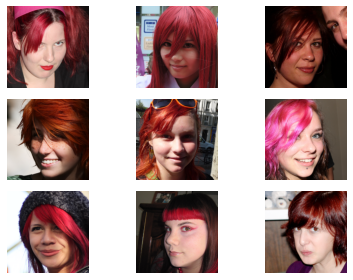

In [34]:
#@title Show Images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
def plot_album(album_name):
    fig, axes = plt.subplots(nrows=3, ncols=3)
    image_paths = imgs
    for imp, ax in zip(image_paths, axes.ravel()):
        img = mpimg.imread(imp)
        ax.imshow(img)
        ax.axis('off')
    fig.tight_layout()
plot_album(imgs)

### `Create a new dataset`

**`Move found Images to new folder.`** "Folder"

In [36]:
import shutil, os
path = "/content/Folder"
os.mkdir(path)
for f in imgs:
    shutil.copy(f, '/content/Folder')

!zip -r /content/Folder.zip /content/Folder
